In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline

from library.sb_utils import save_file

In [2]:
#Import traning and test sets from preprocessing

datapath = "../data/"
X_train = pd.read_csv(datapath+"X_train.csv", index_col=0)
X_test = pd.read_csv(datapath+"X_test.csv", index_col=0)
y_train = pd.read_csv(datapath+"y_train.csv", index_col=0)
y_test = pd.read_csv(datapath+"y_test.csv", index_col=0)
#X_train = np.genfromtxt(datapath+"X_train.csv", delimiter=',')
#X_test = np.genfromtxt(datapath+"X_test.csv", delimiter=',')
#y_train = np.genfromtxt(datapath+"y_train.csv", delimiter=',')
#y_test = np.genfromtxt(datapath+"y_test.csv", delimiter=',')
#columns = np.genfromtxt(datapath+"columns.csv", delimiter=',', dtype=None, encoding='utf-8')

In [3]:
#Scale using robust scaler
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [4]:
#Model 0: Assess performance when all tests come back positive (M=1)
from sklearn.dummy import DummyClassifier

dum_class = DummyClassifier(strategy='constant', constant=1)
dum_class.fit(X_train_scaled, y_train)
y_pred_0 = dum_class.predict(X_test_scaled)

Precision score 0.3742690058479532
Recall score  1.0


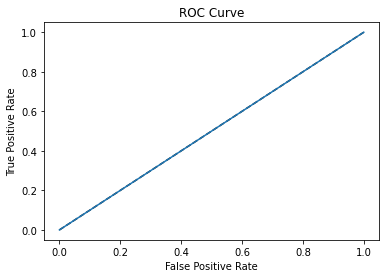

ROC-AUC score : 0.5


In [5]:
#Scoring the not-a-model
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

print('Precision score', metrics.precision_score(y_test,y_pred_0))
print('Recall score ', metrics.recall_score(y_test,y_pred_0))
y_pred_prob = dum_class.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_0))

The purpose of this model is to establish a baseline of randomly guessing that all tests are positive for cancer. The precision score - the proportion of true malignant predictions over all malignant predictions - is about 0.37, which corresponds to the proportion of the tests in the dataset that were classified as malignant. This obviously means that this "model" would over-diagnose over 60% of all tests, which would mean unnecessary intervention, expense, and worry. 


The recall score - the proportion of true malignant predictions over all malignant malignant diagnoses - is 1.0, which makes sense given that all tests were predicted as true. In other words, this model would not miss any tests where malignant cells were present, as it assumes they are all malignant. 

Finally, the ROC-AUC is 0.5, which is associated with randomly guessing. 

This serves as a benchmark through which I will evaluate my modeling efforts. A model that doesn't over diagnose cancer but still doesn't miss cancer is the goal.

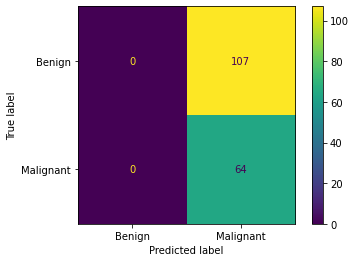

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       107
           1       0.37      1.00      0.54        64

    accuracy                           0.37       171
   macro avg       0.19      0.50      0.27       171
weighted avg       0.14      0.37      0.20       171



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_0))

In [7]:
#Model 1: Naive Logistic Regression
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train_scaled, y_train)
y_pred_1 = clf.predict(X_test_scaled)



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Precision score 0.9838709677419355
Recall score  0.953125


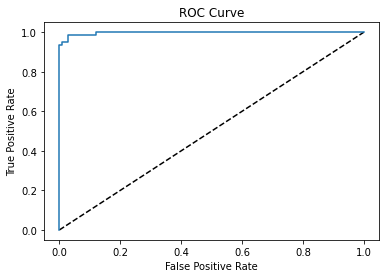

ROC-AUC score : 0.9718896028037384


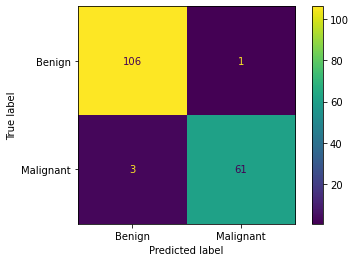

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       107
           1       0.98      0.95      0.97        64

    accuracy                           0.98       171
   macro avg       0.98      0.97      0.97       171
weighted avg       0.98      0.98      0.98       171



In [8]:
print('Precision score', metrics.precision_score(y_test,y_pred_1))
print('Recall score ', metrics.recall_score(y_test,y_pred_1))
y_pred_prob = clf.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_1))

cm = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_1))

This is actually not terrible in terms of prediction. It correctly predicts all but 3 of the cases. However, the 3 incorrectly classified cases are false negatives, which are the worst type of error that we can have. Also, the coefficients on this regression do not lend themselves to interpretation, due to the high degree of collinearity and multi-collinearity between the features.

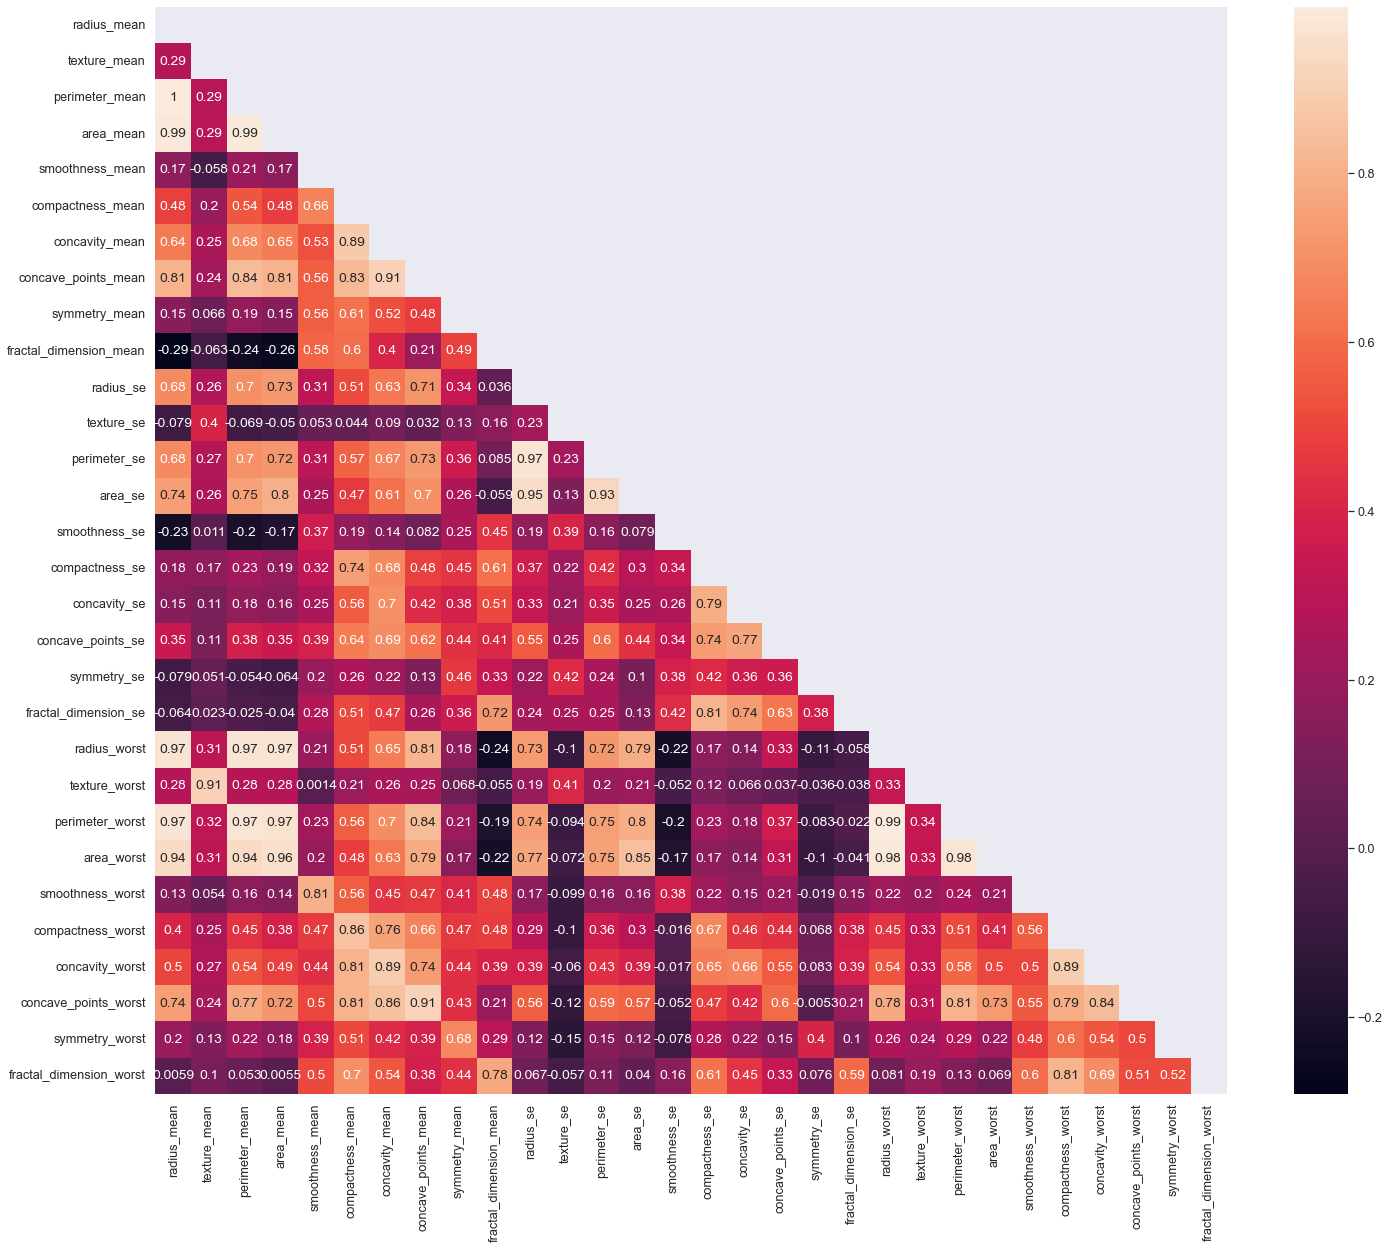

In [9]:
#Generate Heatmap of features

sns.set(font_scale=1.15)
plt.subplots(figsize=(24,20))
# Compute the correlation matrix
corr = X_train_scaled.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

_ = sns.heatmap(corr, annot=True, mask=mask)
plt.show()

First, we need to identify the highly correlated features (>0.95), and drop all but 1.
These features are:

-radius_mean
-perimeter_mean
-area_mean
-radius_se
-radius_worst
-perimeter_worst

In [10]:
#Manual Feature selection
#note that there are still some very highly correlated features, but these are the worst

dropfeatures = ['radius_mean', 'area_mean', 'radius_se', 'radius_worst','perimeter_worst']

X_train_1 = X_train_scaled.drop(columns=dropfeatures)
X_test_1 = X_test_scaled.drop(columns=dropfeatures)



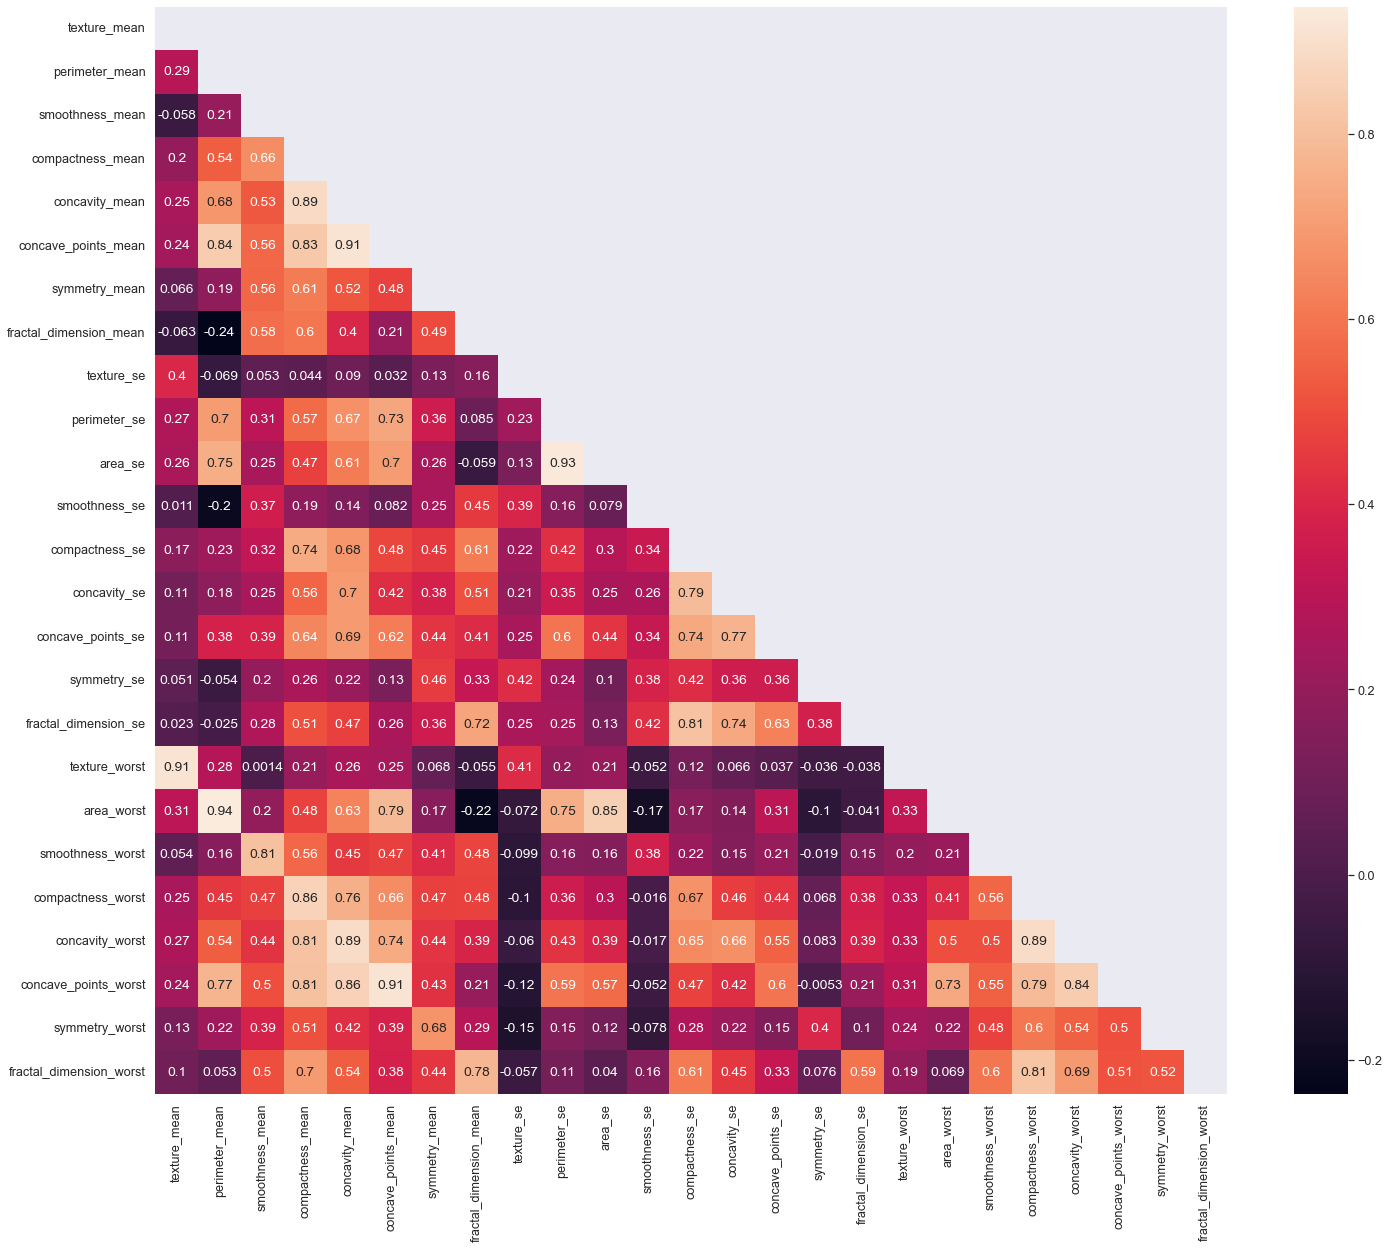

In [11]:
#Check a new heatmap to confirm 
plt.subplots(figsize=(24,20))
# Compute the correlation matrix
corr = X_train_1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

_ = sns.heatmap(corr, annot=True, mask=mask)
plt.show()

In [12]:
#VIF scores
#from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#add a constant to the training set
X_train_VIF_1 = sm.add_constant(X_train_1)
X_train_VIF_2 = sm.add_constant(X_train_1)
X_train_VIF_3 = sm.add_constant(X_train_1)
X_train_VIF_4 = sm.add_constant(X_train_1)

#features = "+".join(X_train_1.columns)
#training_set = pd.concat([X_train, y_train], axis=1)

# get y and X dataframes based on this regression:
#y, X = dmatrices('diagnosis ~' + features, training_set, return_type='dataframe')

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [13]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,2.3,const
1,10.5,texture_mean
2,25.3,perimeter_mean
3,8.5,smoothness_mean
4,33.2,compactness_mean
5,74.1,concavity_mean
6,60.5,concave_points_mean
7,4.2,symmetry_mean
8,14.8,fractal_dimension_mean
9,4.0,texture_se


Ideally, the features in my model should have a VIF score below 5. As such, I will need to drop features until I come to a set of features with much less multicollinearity. 

However, there is not a hard and fast rule for how to choose which features to drop. There are many factors that go into diagnosing the presence of malignant cells, including their size, shape, and regularity. As such, a handful of different models with be produced after dropping different sets of features.

Following my exploratory analysis, I will prioritize keeping the "worst" features in my models, and will deprioritize keeping the "se" features in my models. The operating intuition in this case is that when diagnosing a tissue biopsy, the most extreme observations will be of particular interest. We aren't necessarily trying to characterize the whole sample as indicating the presence of cancer, but rather determining whether there is any evidence of cancer that would call for further intervention.

For my first VIF model, I will start by dropping the compactness features. They do not appear to be important, and seem to interact with a number of other features in undesireable ways.

I will focus on 3 VIF models: one where I prioritize keeping Concave_points_worst, one where I prioritize keeping Concave_points_mean, one where I prioritize keeping concavity worst, and one where I don't prioritize keeping any of these features. The reasoning is that the concavity and concave points features are highly correlated to the point where they are effectively mutually exclusive, so I want to see what happens when I focus on keeping one of these features around while being more flexible with others.

In [14]:
#Drop all concavity related features besides concave_points_worst, recalculate
X_train_VIF_1.drop(columns=["concavity_mean", "concave_points_mean", "concavity_worst", 
                            "concave_points_se", "concavity_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.7,const
1,10.4,texture_mean
2,22.7,perimeter_mean
3,7.2,smoothness_mean
4,24.7,compactness_mean
5,4.1,symmetry_mean
6,14.2,fractal_dimension_mean
7,4.0,texture_se
8,12.6,perimeter_se
9,16.3,area_se


Next I will drop the compactness related features, which are derrived from the size-related features and show evidence of contributing little to the model.

In [15]:
#Drop compactness related features
X_train_VIF_1.drop(columns=["compactness_mean", "compactness_se", "compactness_worst"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.6,const
1,10.3,texture_mean
2,16.7,perimeter_mean
3,6.9,smoothness_mean
4,3.9,symmetry_mean
5,8.5,fractal_dimension_mean
6,3.8,texture_se
7,12.3,perimeter_se
8,16.0,area_se
9,3.7,smoothness_se


In [16]:
#Drop perimeter se, and area se
X_train_VIF_1.drop(columns=["perimeter_se", "area_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.6,const
1,10.0,texture_mean
2,15.0,perimeter_mean
3,6.7,smoothness_mean
4,3.8,symmetry_mean
5,8.2,fractal_dimension_mean
6,3.7,texture_se
7,3.7,smoothness_se
8,4.3,symmetry_se
9,3.8,fractal_dimension_se


In [17]:
#Drop smoothness_mean and smoothness_se, recalculate
X_train_VIF_1.drop(columns=["smoothness_mean", "smoothness_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.5,const
1,9.5,texture_mean
2,13.9,perimeter_mean
3,3.3,symmetry_mean
4,7.3,fractal_dimension_mean
5,3.4,texture_se
6,3.8,symmetry_se
7,3.5,fractal_dimension_se
8,14.1,texture_worst
9,9.1,area_worst


In [18]:
#Drop texture_mean and texture_se, recalculate
X_train_VIF_1.drop(columns=["texture_mean", "texture_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.4,const
1,13.6,perimeter_mean
2,2.8,symmetry_mean
3,7.3,fractal_dimension_mean
4,2.5,symmetry_se
5,3.4,fractal_dimension_se
6,1.3,texture_worst
7,9.0,area_worst
8,2.5,smoothness_worst
9,7.1,concave_points_worst


In [19]:
#Drop perimeter_mean
X_train_VIF_1.drop(columns=["perimeter_mean"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.3,const
1,2.8,symmetry_mean
2,6.8,fractal_dimension_mean
3,2.5,symmetry_se
4,3.4,fractal_dimension_se
5,1.3,texture_worst
6,3.4,area_worst
7,2.4,smoothness_worst
8,4.8,concave_points_worst
9,4.3,symmetry_worst


In [20]:
#Drop fractal_dimension_se
X_train_VIF_1.drop(columns=["fractal_dimension_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.3,const
1,2.7,symmetry_mean
2,6.4,fractal_dimension_mean
3,2.1,symmetry_se
4,1.2,texture_worst
5,3.4,area_worst
6,2.1,smoothness_worst
7,4.8,concave_points_worst
8,3.6,symmetry_worst
9,6.4,fractal_dimension_worst


In [21]:
#Drop fractal_dimension_mean
X_train_VIF_1.drop(columns=["fractal_dimension_mean"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_1.values, i) for i in range(X_train_VIF_1.shape[1])]
vif["features"] = X_train_VIF_1.columns
vif.round(1)

,VIF Factor,features
0,1.3,const
1,2.3,symmetry_mean
2,1.5,symmetry_se
3,1.2,texture_worst
4,3.2,area_worst
5,1.9,smoothness_worst
6,4.7,concave_points_worst
7,2.5,symmetry_worst
8,2.3,fractal_dimension_worst


Success! Let's look at a heatmap of the features

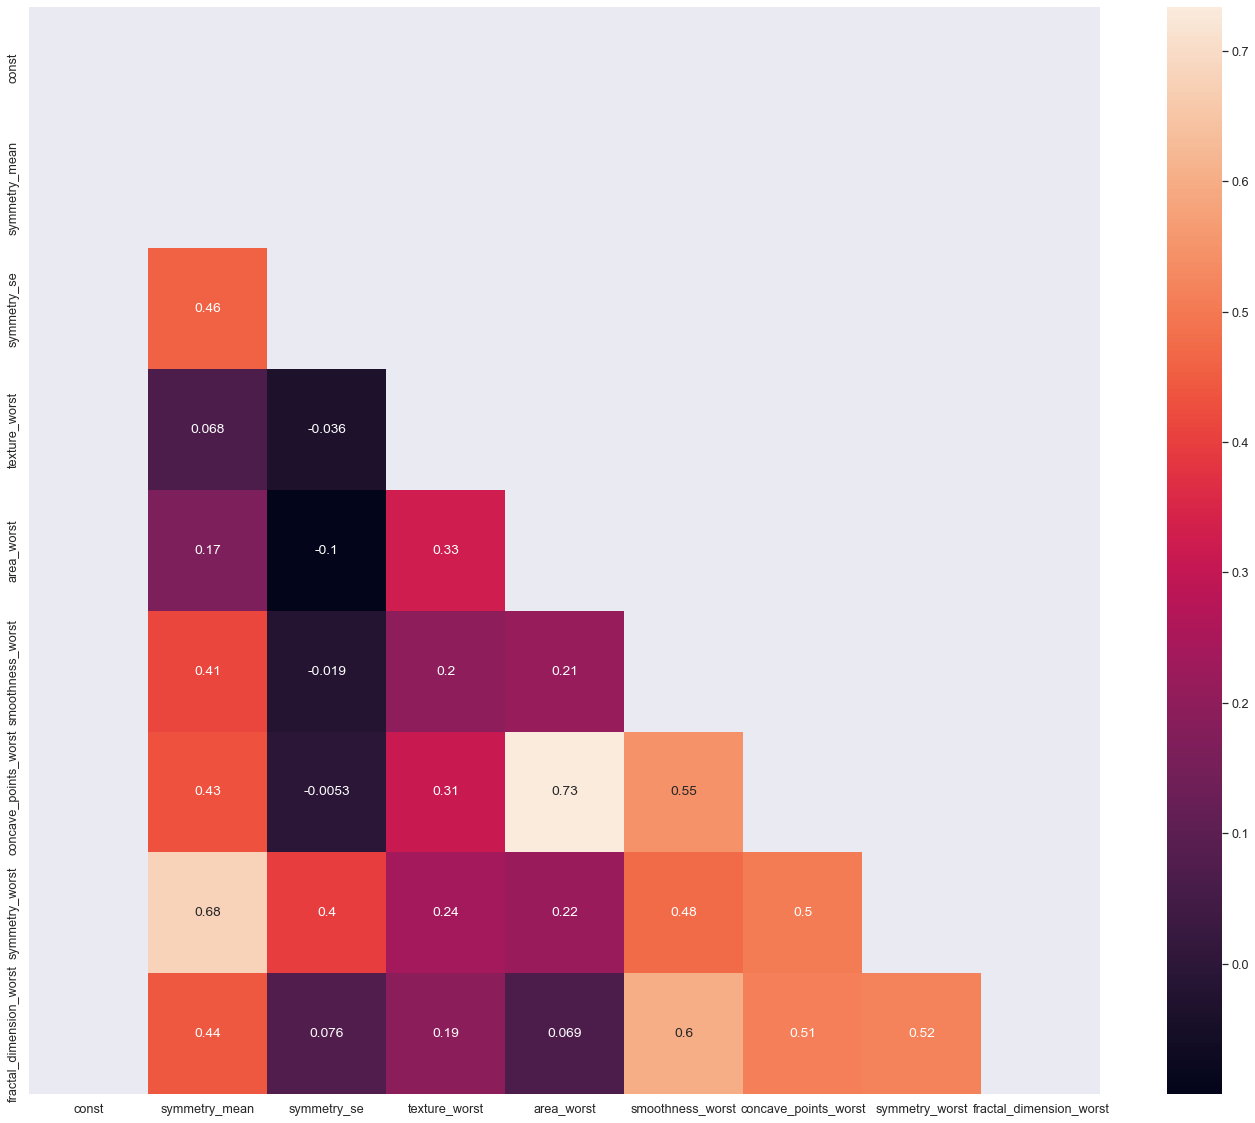

In [22]:
#Check a new heatmap to confirm 
plt.subplots(figsize=(24,20))
# Compute the correlation matrix
corr = X_train_VIF_1.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

_ = sns.heatmap(corr, annot=True, mask=mask)
plt.show()

In [23]:
#Perform logistic regression (using sm)
log_reg = sm.Logit(y_train, X_train_VIF_1).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.085035
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                  0.8711
Time:                        20:30:14   Log-Likelihood:                -33.844
converged:                       True   LL-Null:                       -262.66
Covariance Type:            nonrobust   LLR p-value:                 8.599e-94
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.2069      0.557     -5.762      0.000      -4.298  

Only 3 features here are shown to have statistically significant coefficients: texture_worst, area_worst, and smoothness worst. It would seem that my feature selection was suboptimal for the purposes of logistic regression. I will try again with a different group of features.

In [24]:
#perform unscaled regression for interpreting the coefficients
features = X_train_VIF_1.columns
X_train_VIF_1_unscaled = sm.add_constant(X_train)
X_train_VIF_1_unscaled = X_train_VIF_1_unscaled[features]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [25]:
log_reg = sm.Logit(y_train, X_train_VIF_1_unscaled).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.085035
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      389
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                  0.8711
Time:                        20:30:15   Log-Likelihood:                -33.844
converged:                       True   LL-Null:                       -262.66
Covariance Type:            nonrobust   LLR p-value:                 8.599e-94
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     -30.5361      6.025     -5.068      0.000     -42.346  

In [26]:
probs = []

for coef in log_reg.params:
    log_reg.params

In [27]:
print("All else equal, the baseline probability that a given test will return positive for breast cancer is "
     + str(math.exp(log_reg.params[0])/(math.exp(log_reg.params[0])+1)))
print("All else equal, a 1 pixel increase in " + str(log_reg.params.index[1]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[1])))
print("All else equal, a 1 pixel increase in " + str(log_reg.params.index[2]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[2])))
print("All else equal, a unit grayscale variance increase in " + str(log_reg.params.index[3]) +"multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[3])))
print("All else equal, a 1 pixel increase in " + str(log_reg.params.index[4]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[4])))
print("All else equal, a 1 pixel increase in " + str(log_reg.params.index[5]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[5])))
print("All else equal, each additional point in " + str(log_reg.params.index[6]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[6])))
print("All else equal, a 1 pixel increase in " + str(log_reg.params.index[7]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[7])))
print("All else equal, a unit increase in " + str(log_reg.params.index[8]) +" multiplies the odds of breast cancer by " + str(math.exp(log_reg.params[8])))

All else equal, the baseline probability that a given test will return positive for breast cancer is 5.4743553849315355e-14
All else equal, a 1 pixel increase in symmetry_mean multiplies the odds of breast cancer by 0.2542625194638963
All else equal, a 1 pixel increase in symmetry_se multiplies the odds of breast cancer by 1.2413447809309397
All else equal, a unit grayscale variance increase in texture_worstmultiplies the odds of breast cancer by 1.2843229203619542
All else equal, a 1 pixel increase in area_worst multiplies the odds of breast cancer by 1.0158175093680935
All else equal, a 1 pixel increase in smoothness_worst multiplies the odds of breast cancer by 6.105827760730614e+35
All else equal, each additional point in concave_points_worst multiplies the odds of breast cancer by 16540239769.206371
All else equal, a 1 pixel increase in symmetry_worst multiplies the odds of breast cancer by 0.11921299092012112
All else equal, a unit increase in fractal_dimension_worst multiplies t

In [28]:
features1 = X_train_VIF_1.columns[1:]
X_train_select = X_train_scaled[features1]
X_test_select = X_test_scaled[features1]
clf2 = LogisticRegression()
clf2.fit(X_train_select, y_train)
y_pred_2 = clf2.predict(X_test_select)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Precision score 0.984375
Recall score  0.984375


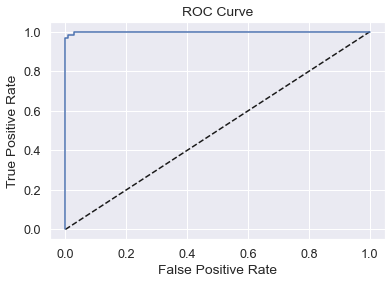

ROC-AUC score : 0.9875146028037384


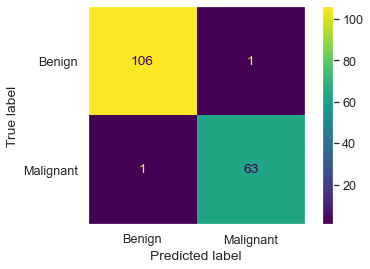

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       107
           1       0.98      0.98      0.98        64

    accuracy                           0.99       171
   macro avg       0.99      0.99      0.99       171
weighted avg       0.99      0.99      0.99       171



In [29]:
print('Precision score', metrics.precision_score(y_test,y_pred_2))
print('Recall score ', metrics.recall_score(y_test,y_pred_2))
y_pred_prob = clf2.predict_proba(X_test_select)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_2))
cm = confusion_matrix(y_test, y_pred_2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_2))


In [30]:
#Bar Chart

#probs = lambda x: np.exp(x)/(np.exp(x)+1)
probs = lambda x: np.exp(x)
coefs = log_reg.params.apply(probs)
lower = log_reg.conf_int()[0].apply(probs)
upper = log_reg.conf_int()[1].apply(probs)
upper["smoothness_se"]=1


In [31]:
coefs.index[3:6]

Index(['texture_worst', 'area_worst', 'smoothness_worst'], dtype='object')

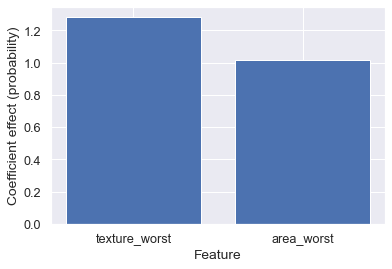

In [32]:

fig, ax = plt.subplots()
ax = plt.bar(coefs.index[3:5], coefs.values[3:5])
plt.ylabel("Coefficient effect (probability)");
plt.xlabel("Feature");


In [33]:
coefs.index

Index(['const', 'symmetry_mean', 'symmetry_se', 'texture_worst', 'area_worst',
       'smoothness_worst', 'concave_points_worst', 'symmetry_worst',
       'fractal_dimension_worst'],
      dtype='object')

In [34]:
#Drop all concavity related features besides concave_points_mean, recalculate
X_train_VIF_2.drop(columns=["concavity_mean", "concave_points_worst", "concavity_worst", 
                            "concave_points_se", "concavity_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.9,const
1,10.3,texture_mean
2,25.2,perimeter_mean
3,7.4,smoothness_mean
4,27.5,compactness_mean
5,14.4,concave_points_mean
6,4.1,symmetry_mean
7,14.3,fractal_dimension_mean
8,4.0,texture_se
9,12.1,perimeter_se


In [35]:
#Drop all compactness related features 
X_train_VIF_2.drop(columns=["compactness_mean", "compactness_se", "compactness_worst"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.8,const
1,10.2,texture_mean
2,21.6,perimeter_mean
3,7.2,smoothness_mean
4,12.0,concave_points_mean
5,4.0,symmetry_mean
6,8.8,fractal_dimension_mean
7,3.8,texture_se
8,11.7,perimeter_se
9,15.6,area_se


In [36]:
#Drop fractal_dimension mean and worst, and all symmetry related features
X_train_VIF_2.drop(columns=["fractal_dimension_mean", "fractal_dimension_worst", "symmetry_mean", "symmetry_se"
                           , "symmetry_worst"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.7,const
1,9.5,texture_mean
2,17.3,perimeter_mean
3,5.8,smoothness_mean
4,10.3,concave_points_mean
5,3.1,texture_se
6,11.0,perimeter_se
7,15.0,area_se
8,2.8,smoothness_se
9,1.6,fractal_dimension_se


In [37]:
#Drop perimeter_se, area_se, perimeter_mean
X_train_VIF_2.drop(columns=["area_se", "perimeter_se", "perimeter_mean"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.4,const
1,8.9,texture_mean
2,5.6,smoothness_mean
3,5.7,concave_points_mean
4,2.9,texture_se
5,2.6,smoothness_se
6,1.5,fractal_dimension_se
7,12.9,texture_worst
8,4.1,area_worst
9,7.2,smoothness_worst


In [38]:
#Drop texture_se
X_train_VIF_2.drop(columns=["texture_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.3,const
1,7.7,texture_mean
2,4.4,smoothness_mean
3,5.7,concave_points_mean
4,1.6,smoothness_se
5,1.5,fractal_dimension_se
6,8.3,texture_worst
7,4.1,area_worst
8,4.1,smoothness_worst


In [39]:
#Drop texture_mean
X_train_VIF_2.drop(columns=["texture_mean"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.3,const
1,4.4,smoothness_mean
2,5.6,concave_points_mean
3,1.5,smoothness_se
4,1.5,fractal_dimension_se
5,1.3,texture_worst
6,4.1,area_worst
7,3.5,smoothness_worst


In [40]:
#Drop texture_se
X_train_VIF_2.drop(columns=["smoothness_mean", "smoothness_se"], inplace=True)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_train_VIF_2.values, i) for i in range(X_train_VIF_2.shape[1])]
vif["features"] = X_train_VIF_2.columns
vif.round(1)

,VIF Factor,features
0,1.2,const
1,4.4,concave_points_mean
2,1.3,fractal_dimension_se
3,1.2,texture_worst
4,3.6,area_worst
5,1.4,smoothness_worst


In [41]:
#Perform logistic regression (using sm)
log_reg = sm.Logit(y_train, X_train_VIF_2).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.077670
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:              diagnosis   No. Observations:                  398
Model:                          Logit   Df Residuals:                      392
Method:                           MLE   Df Model:                            5
Date:                Sun, 28 Aug 2022   Pseudo R-squ.:                  0.8823
Time:                        20:30:16   Log-Likelihood:                -30.913
converged:                       True   LL-Null:                       -262.66
Covariance Type:            nonrobust   LLR p-value:                 6.055e-98
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -3.5000      0.580     -6.030      0.000      -4.638      -2.36

In [43]:
features2 = X_train_VIF_2.columns[1:]
X_train_select = X_train_scaled[features2]
X_test_select = X_test_scaled[features2]
clf3 = LogisticRegression()
clf3.fit(X_train_select, y_train)
y_pred_3 = clf3.predict(X_test_select)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Precision score 0.967741935483871
Recall score  0.9375


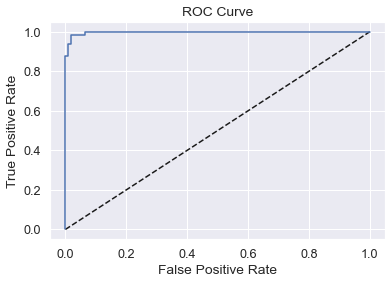

ROC-AUC score : 0.9594042056074766


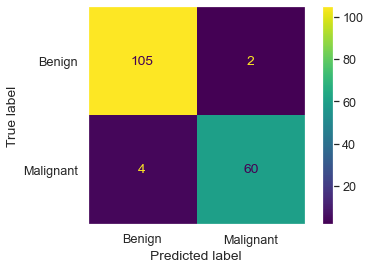

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       107
           1       0.97      0.94      0.95        64

    accuracy                           0.96       171
   macro avg       0.97      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [44]:
print('Precision score', metrics.precision_score(y_test,y_pred_3))
print('Recall score ', metrics.recall_score(y_test,y_pred_3))
y_pred_prob = clf3.predict_proba(X_test_select)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_3))
cm = confusion_matrix(y_test, y_pred_3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_3))


In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
import shap
from collections import OrderedDict

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


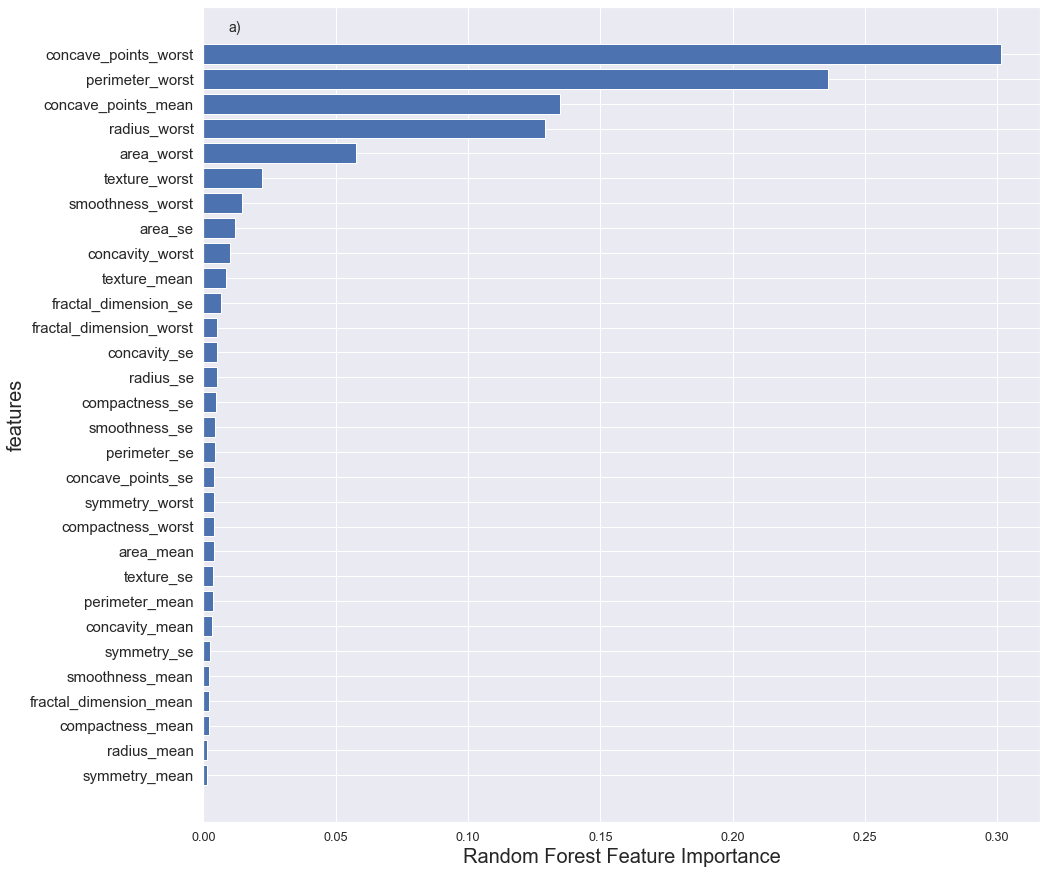

In [46]:
#1 Feature importances: all columns, scaled, random forest
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_scaled, y_train)
sorted_idx = rf.feature_importances_.argsort()

fig, ax = plt.subplots(figsize=(15,15))
ax = plt.barh(X_train_scaled.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance", fontsize=20);
plt.ylabel("features", fontsize=20);
plt.yticks(fontsize=15);
plt.annotate("a)", xy=(0.03, 0.97), xycoords='axes fraction', fontsize=14)
plt.show()

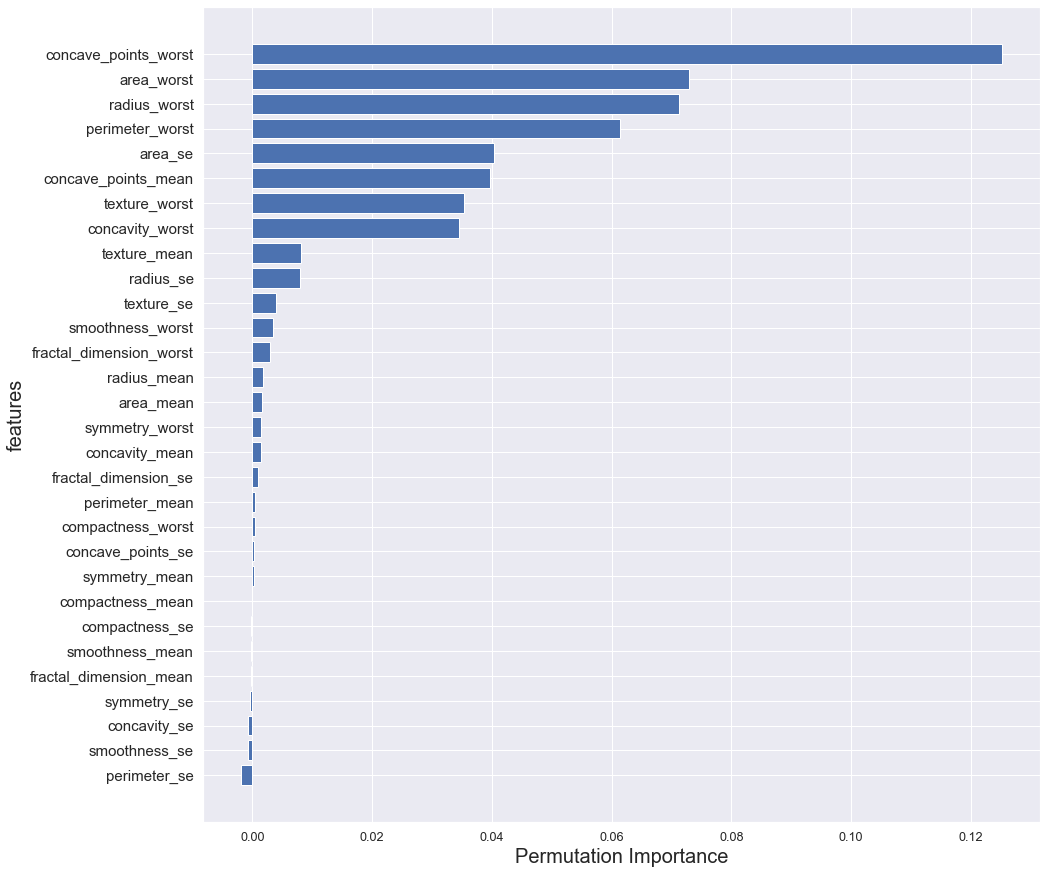

In [47]:
#2 Feature importances: all columns, scaled, permutation-based
perm_importance = permutation_importance(rf, X_test_scaled, y_test)

sorted_idx = perm_importance.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(15,15))
ax = plt.barh(X_test_scaled.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance", fontsize=20);
plt.ylabel("features", fontsize=20);
plt.yticks(fontsize=15);

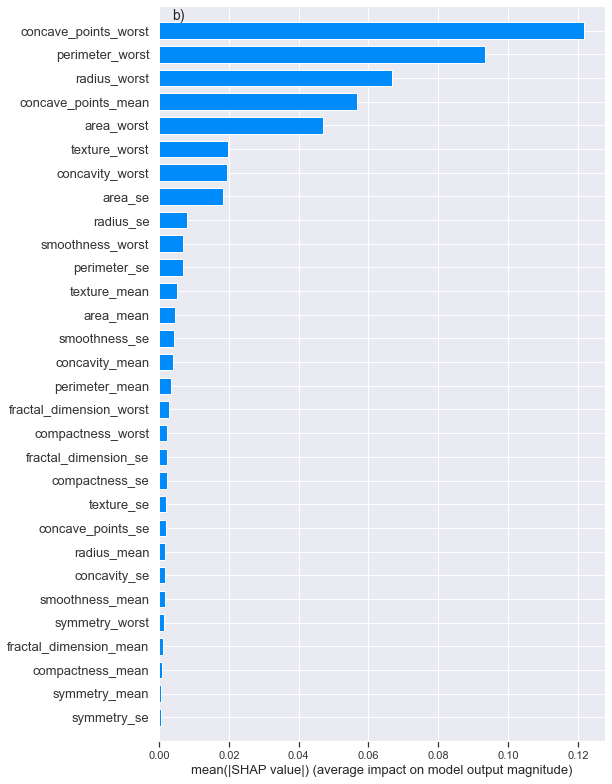

In [48]:
#3: Shap based featured importance: all columns, scaled


explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_scaled)
shap.summary_plot(shap_values, X_test_scaled, plot_type="bar", max_display=30, show=False)
plt.annotate("b)", xy=(0.03, 0.983), xycoords='axes fraction', fontsize=14)
plt.show()

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Precision score 0.9830508474576272
Recall score  0.90625


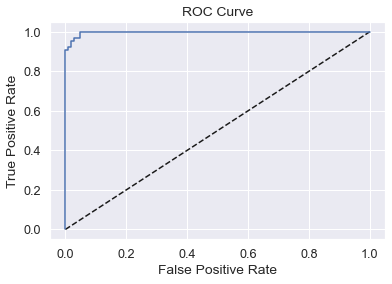

ROC-AUC score : 0.9484521028037383


In [49]:
clf = LogisticRegression(C=0.1)
clf.fit(X_train_select, y_train)
y_pred_1 = clf.predict(X_test_select)

print('Precision score', metrics.precision_score(y_test,y_pred_1))
print('Recall score ', metrics.recall_score(y_test,y_pred_1))
y_pred_prob = clf.predict_proba(X_test_select)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_1))

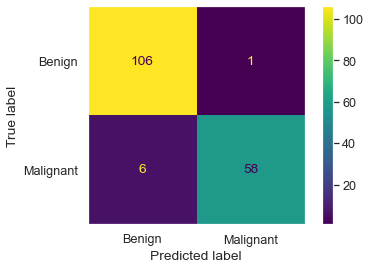

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       107
           1       0.98      0.91      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171



In [50]:
cm = confusion_matrix(y_test, y_pred_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_1))

In [51]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import f1_score

pipe = make_pipeline(
    RobustScaler(),
    SelectKBest(f_classif),
    LogisticRegression()
)



In [52]:
k = [k+1 for k in range(X_train.shape[1])]
grid_params = {'selectkbest__k': k}
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('selectkbest', SelectKBest()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30]})

Precision score 0.9682539682539683
Recall score  0.953125


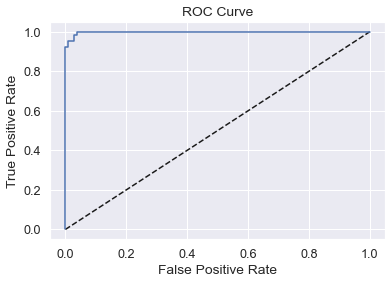

ROC-AUC score : 0.9672167056074766


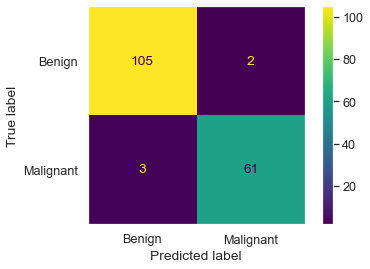

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.97      0.95      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'radius_se', 'perimeter_se',
       'area_se', 'concave_points_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst'],
      dtype='object')


In [53]:
y_pred_skb = lr_grid_cv.predict(X_test)
print('Precision score', metrics.precision_score(y_test,y_pred_skb))
print('Recall score ', metrics.recall_score(y_test,y_pred_skb))
y_pred_prob = lr_grid_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_skb))
cm = confusion_matrix(y_test, y_pred_skb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_skb))

selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

print(X_train.columns[selected])

In [54]:
#Model 2: KNN
from sklearn.neighbors import KNeighborsClassifier

klist = np.arange(0,11)
grid_params = {'kneighborsclassifier__n_neighbors': klist}

pipe = make_pipeline(
    RobustScaler(),
    KNeighborsClassifier()
)

knn_grid_cv = GridSearchCV(pipe, param_grid=grid_params, scoring='roc_auc', cv=5, n_jobs=-1)
knn_grid_cv.fit(X_train,y_train)
y_pred_knn = knn_grid_cv.predict(X_test)

One or more of the test scores are non-finite: [       nan 0.95432184 0.97386207 0.97925517 0.98882069 0.98774253
 0.98752184 0.9873908  0.98630805 0.98932184 0.98884828]
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Precision score 0.9841269841269841
Recall score  0.96875


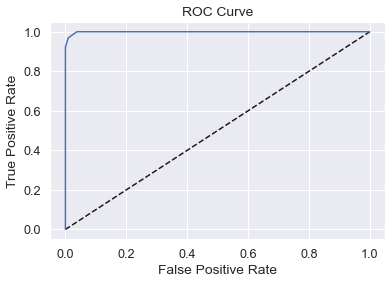

ROC-AUC score : 0.9797021028037383


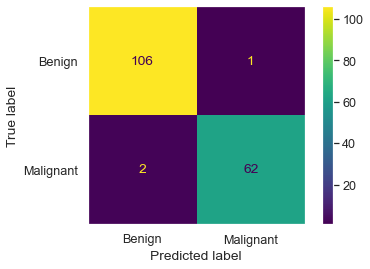

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       107
           1       0.98      0.97      0.98        64

    accuracy                           0.98       171
   macro avg       0.98      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [55]:
print('Precision score', metrics.precision_score(y_test,y_pred_knn))
print('Recall score ', metrics.recall_score(y_test,y_pred_knn))
y_pred_prob = knn_grid_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_knn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_knn))

In [56]:
#Model 3: SVM
from sklearn.svm import SVC


gammas = [0.1, 1, 10, 100]
Cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6]
kernels = ["rbf", "poly"]

grid_params = {'svc__C': Cs, 'svc__kernel': kernels, 'svc__degree': degrees, 'svc__gamma': gammas}

pipe = make_pipeline(
    RobustScaler(),
    SVC(probability=True)
)

svm_grid_cv = GridSearchCV(pipe, param_grid=grid_params, scoring='roc_auc', cv=5, n_jobs=-1)



In [57]:
svm_grid_cv.fit(X_train, y_train)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('robustscaler', RobustScaler()),
                                       ('svc', SVC(probability=True))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100, 1000],
                         'svc__degree': [0, 1, 2, 3, 4, 5, 6],
                         'svc__gamma': [0.1, 1, 10, 100],
                         'svc__kernel': ['rbf', 'poly']},
             scoring='roc_auc')

Precision score 1.0
Recall score  0.953125


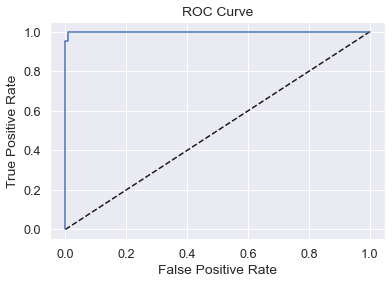

ROC-AUC score : 0.9765625


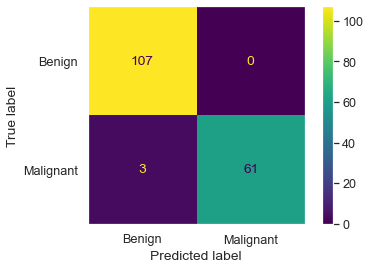

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       107
           1       1.00      0.95      0.98        64

    accuracy                           0.98       171
   macro avg       0.99      0.98      0.98       171
weighted avg       0.98      0.98      0.98       171



In [58]:
y_pred_svm = svm_grid_cv.predict(X_test)
print('Precision score', metrics.precision_score(y_test,y_pred_svm))
print('Recall score ', metrics.recall_score(y_test,y_pred_svm))
y_pred_prob = svm_grid_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_svm))
cm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_svm))

In [59]:
recalls = metrics.recall_score(thresholds, y_pred_svm)
precisions = metrics.precision_score(thresholds, y_pred_svm)

plt.plot(thresholds, recalls)
plt.plot(thresholds, precisions)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [6, 171]

In [68]:
#Model 4: Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


rf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
ran_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_ran_cv = RandomizedSearchCV(rf, param_distributions=ran_params, scoring='roc_auc', cv=5, n_iter = 100, verbose=2, n_jobs=-1)

In [69]:
rf_ran_cv.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='roc_auc', verbose=2)

In [70]:
rf_ran_cv.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 40,
 'bootstrap': False}

In [71]:
#Grid search

rf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [50, 100, 200, 300, 400, 1000]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [10, 20, 30, 40, 50]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
grid_params = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_grid_cv = GridSearchCV(rf, param_grid=grid_params, scoring='roc_auc', cv=5, verbose=2, n_jobs=-1)

In [72]:
rf_grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'max_depth': [10, 20, 30, 40, 50, None],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 400, 1000]},
             scoring='roc_auc', verbose=2)

Precision score 0.9253731343283582
Recall score  0.96875


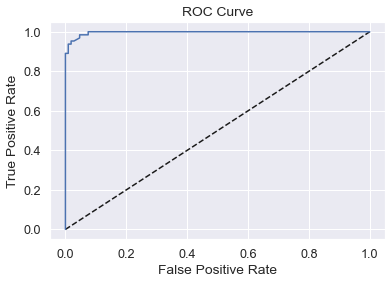

ROC-AUC score : 0.9610105140186915


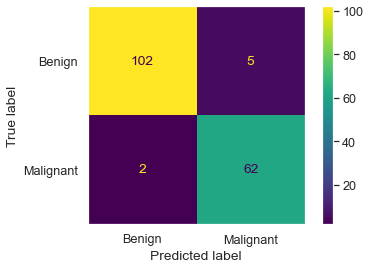

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       107
           1       0.93      0.97      0.95        64

    accuracy                           0.96       171
   macro avg       0.95      0.96      0.96       171
weighted avg       0.96      0.96      0.96       171



In [73]:
y_pred_rf = rf_grid_cv.predict(X_test)
print('Precision score', metrics.precision_score(y_test,y_pred_rf))
print('Recall score ', metrics.recall_score(y_test,y_pred_rf))
y_pred_prob = rf_grid_cv.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_rf))

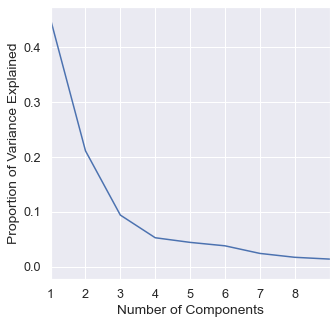

In [74]:
#PCA versions of 1
from sklearn.decomposition import PCA


pipe = make_pipeline(
    RobustScaler(),
    PCA()
)

pipe.fit(X_train)
evr = pipe['pca'].explained_variance_ratio_


fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

plt.plot(np.arange(1, len(evr)+1, 1), evr)

ax1.set_xlim([1, 9])
ax1.set_xticks(range(1,9))
# Label the axes
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")
plt.show()


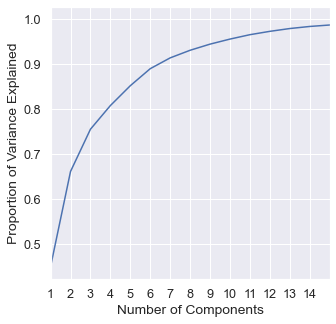

In [75]:
cvr = np.cumsum(evr)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(5, 5)

plt.plot(np.arange(1, len(evr)+1, 1), cvr)

ax1.set_xlim([1, 15])
ax1.set_xticks(range(1,15))
# Label the axes
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")
plt.show()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Precision score 0.9682539682539683
Recall score  0.953125


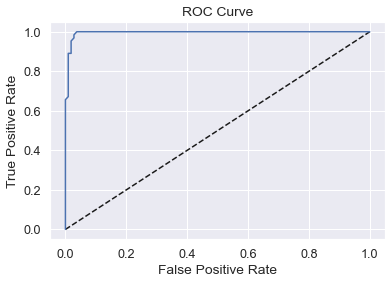

ROC-AUC score : 0.9672167056074766


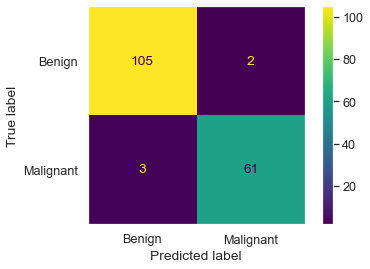

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       107
           1       0.97      0.95      0.96        64

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



In [76]:
pipe = make_pipeline(
    RobustScaler(),
    PCA(n_components = 0.95)
)

X_train_pca = pipe.fit_transform(X_train)
X_test_pca = pipe.transform(X_test)

rf_pca = RandomForestClassifier()

rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_test_pca)
print('Precision score', metrics.precision_score(y_test,y_pred_rf_pca))
print('Recall score ', metrics.recall_score(y_test,y_pred_rf_pca))
y_pred_prob = rf_pca.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_rf_pca))
cm = confusion_matrix(y_test, y_pred_rf_pca)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_rf_pca))

In [77]:
from sklearn.metrics import fbeta_score
threshold_df = pd.DataFrame(columns = ["threshold", "precision", "recall", "f2"])


for t in np.arange(0.1, 1, 0.1):
    y_pred = (rf_pca.predict_proba(X_test_pca)[:,1]>=t).astype(bool)
    precision = metrics.precision_score(y_test,y_pred)
    recall = metrics.recall_score(y_test,y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    row = {"threshold":t, "precision":precision, "recall":recall, "f2":f2}
    print(row)
    threshold_df = threshold_df.append(row, ignore_index=True)

{'threshold': 0.1, 'precision': 0.6530612244897959, 'recall': 1.0, 'f2': 0.903954802259887}
{'threshold': 0.2, 'precision': 0.810126582278481, 'recall': 1.0, 'f2': 0.9552238805970151}
{'threshold': 0.30000000000000004, 'precision': 0.8767123287671232, 'recall': 1.0, 'f2': 0.9726443768996961}
{'threshold': 0.4, 'precision': 0.9142857142857143, 'recall': 1.0, 'f2': 0.98159509202454}
{'threshold': 0.5, 'precision': 0.9538461538461539, 'recall': 0.96875, 'f2': 0.9657320872274141}
{'threshold': 0.6, 'precision': 0.9666666666666667, 'recall': 0.90625, 'f2': 0.9177215189873417}
{'threshold': 0.7000000000000001, 'precision': 0.9814814814814815, 'recall': 0.828125, 'f2': 0.8548387096774195}
{'threshold': 0.8, 'precision': 0.9803921568627451, 'recall': 0.78125, 'f2': 0.8143322475570031}
{'threshold': 0.9, 'precision': 0.9772727272727273, 'recall': 0.671875, 'f2': 0.7166666666666667}


0.9561128526645767


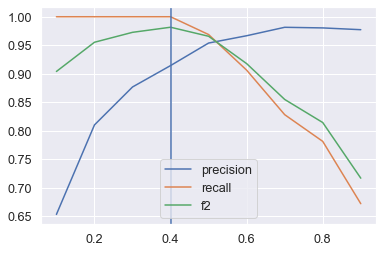

In [78]:

fig, ax1 = plt.subplots(1,1);

plt.plot(threshold_df["threshold"], threshold_df["precision"], label = "precision");
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="recall")
plt.plot(threshold_df["threshold"], threshold_df["f2"], label="f2")
plt.axvline(x=0.4)
plt.legend()
f_beta2 = fbeta_score(y_test, y_pred_rf_pca, beta=2)
print(f_beta2)

Precision score 0.9142857142857143
Recall score  1.0


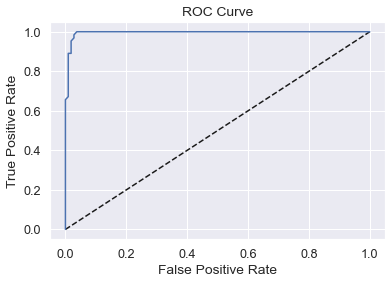

ROC-AUC score : 0.9719626168224299


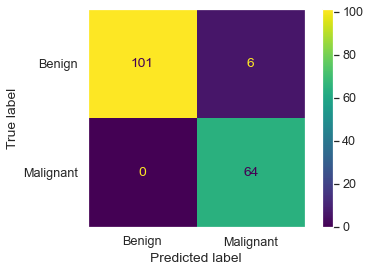

              precision    recall  f1-score   support

           0       1.00      0.94      0.97       107
           1       0.91      1.00      0.96        64

    accuracy                           0.96       171
   macro avg       0.96      0.97      0.96       171
weighted avg       0.97      0.96      0.97       171



In [79]:
y_pred_rf_pca40 = (rf_pca.predict_proba(X_test_pca)[:,1]>=0.4).astype(bool)
print('Precision score', metrics.precision_score(y_test,y_pred_rf_pca40))
print('Recall score ', metrics.recall_score(y_test,y_pred_rf_pca40))
y_pred_prob = rf_pca.predict_proba(X_test_pca)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print("ROC-AUC score :", roc_auc_score(y_test, y_pred_rf_pca40))
cm = confusion_matrix(y_test, y_pred_rf_pca40)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot()
plt.grid(False)
plt.show()
print(classification_report(y_test, y_pred_rf_pca40))